# <center> Practice: Statistical Tests in the Context of EDA

## Task Discription: 

An HR agency is studying labor market trends in IT. The company aims to conduct research based on salary data in the IT industry for the years 2020–2022.

This research aims to identify the **key factors influencing the salaries of Data Scientists**. Additionally, it will address key questions posed by the HR agency, including:

* Is there an annual salary increase for Data Scientists?
* How do Data Scientist and Data Engineer salaries compare in 2022?
* How do Data Scientist salaries vary across companies of different sizes?
* Is there a correlation between the presence of Data Scientist and Data Engineer roles and company size?

Any other notable patterns found in the data will also be highlighted in the analysis.

**To ensure statistical validity**, various tests will be applied to assess the significance of the findings, including:

* Tests for continuous variables:
    * Single-sample tests
    * Two-sample tests
    * Multiple-sample tests
* A test for categorical variables.

__The data set includes:__
* **work_year** – The year in which the salary was paid.
* **experience_level** – The level of experience for this position during the year, with the following possible values:
    * **EN** – Entry-level/Junior
    * **MI** – Mid-level/Intermediate
    * **SE** – Senior-level/Expert
    * **EX** – Executive-level/Director
* **employment_type** – Type of employment for this role:
    * **PT** – Part-time
    * **FT** – Full-time
    * **CT** – Contract
    * **FL** – Freelance
* **job_title** – The role in which the employee worked during the year.
* **salary** – The total gross salary paid.
* **salary_currency** – The currency in which the salary was paid, represented as an ISO 4217 currency code.
* **salary_in_usd** – Salary converted to US dollars (exchange rate divided by the average USD rate for the corresponding year via fxdata.foorilla.com).
* **employee_residence** – The primary country of residence of the employee during the work year, represented as an ISO 3166 country code.
* **remote_ratio** – The proportion of work performed remotely, with possible values:
    * **0** – No remote work (less than 20%)
    * **50** – Partially remote work
    * **100** – Fully remote work (more than 80%)
* **company_location** – The country of the employer’s headquarters or contract-based branch, represented as an ISO 3166 country code.
* **company_size** – The average number of employees working at the company during the year:
    * **S** – Fewer than 50 employees (small company)
    * **M** – 50 to 250 employees (medium company)
    * **L** – More than 250 employees (large company)

## Data Loading

In [60]:

# import libraries
import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import chi2_contingency

import statsmodels.api as sm
from statsmodels import stats as sms


import matplotlib.pyplot as plt
import seaborn as sns

# visual settings for the graphs
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [61]:
# read dataset
data = pd.read_csv('data/ds_salaries.csv')
data.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


## Setting the Significance Level


In [62]:
# set significance level
alpha = 0.05 
print("Significance level alpha = {:.2f}".format(alpha))

Significance level alpha = 0.05


## Descriptive Data Analysis

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


In [64]:
# count the number of records in the dataset
record_count = data.dropna().shape[0]

# count the number of missing values in each column
missing_values = data.isnull().sum().sum()

print(f'The dataset contais {record_count} rows with {missing_values} missing values.')



The dataset contais 607 rows with 0 missing values.


Checking for duplicated rows

In [65]:
# count duplicates
print(f"Duplicates count: {data.duplicated().sum()}")

# remove duplicates 
# data = data.drop_duplicates()
# print(f'Size after removing the duplicates: {format(data.shape)}')

Duplicates count: 0


Checking data types

In [66]:
data.dtypes

Unnamed: 0             int64
work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

Features directly relevant to the scope of the research:
* **work_year** for analyzing salary trends over time.
* **salary_in_usd** as a standartised salary for comparison.
* **job_title** to filter Data Scientist and Data Engeneer roles for analysis.
* **company_size** for comparing salaries across companies of different sizes.

The following features are to be removed from the dataset:
* **salary** as we will use salary_in_usd
* **salary_currency** redundant as well
* **row number (Unnamed: 0)** as indexes are not to be used in the analysis

The following features, although not directly relevant to the research questions will be kept in order to analyse the factors that can influence salaries of Data Scientists:
* **employment_type** may affect salary based on job contract type.
* **remote_ratio** for comparing salaries based on the remote/on-site work ratio.
* **employee_residence** for geographic salary analysis.
* **company_location** for regional salary analysis.

"We retain these features to ensure the data remains comparable, allowing for accurate salary comparisons across similar roles and working conditions."
* **employment_type**
* **experience_level**

In [67]:
# remove irrelevant features
columns_to_remove = ["salary", "salary_currency", "Unnamed: 0"]  
data = data.drop(columns=columns_to_remove)
data.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,US,50,US,L


Classifying remaining features into numeric and categorical

In [68]:
data[["experience_level", "employment_type", "job_title", "employee_residence", "company_location", "company_size"]].nunique()


experience_level       4
employment_type        4
job_title             50
employee_residence    57
company_location      50
company_size           3
dtype: int64

The dataset contains

**Numerical Features** (Continuous & Discrete)
* **work_year** (Discrete)
* **salary_in_usd** (Continuous) 
* **remote_ratio** (Discrete) 

**Categorical Features**
* **experience_level** (4 unique values(UnV))
* **employment_type** (4 UnV)
* **job_title** (50 UnV).
* **employee_residence** (57 UnV).
* **company_location** (50).
* **company_size** (3 UnV).

Next, we will explore how Data Scientist jobs are distributed across different values for all the features.

In [69]:
# filter the DataFrame where job_title is 'Data Scientist'
filtered_data = data[data['job_title'] == 'Data Scientist']

# calculate the number of unique values for each column
unique_values = filtered_data.nunique()

# display the result
print(unique_values)

work_year               3
experience_level        3
employment_type         3
job_title               1
salary_in_usd         108
employee_residence     27
remote_ratio            3
company_location       24
company_size            3
dtype: int64


In [70]:
# get the unique values for the 'experience_level' column
unique_experience_levels = filtered_data['experience_level'].unique()

print(unique_experience_levels)


['MI' 'EN' 'SE']



**Note:** the present dataset only shows Data Scientists to work at entry/junior, mid, and senior level, but not at the expert level. Having looked at the dataset, Executive Data Science roles are listed under different titles, such as Head of Data (Science) or Data Science Manager. To address this issue, from now on we will filter for any title that contains "data sc" and not only Data Scientist directly.

In [71]:
# print all the job_titles
job_title_list = data["job_title"].tolist()

print(job_title_list)

['Data Scientist', 'Machine Learning Scientist', 'Big Data Engineer', 'Product Data Analyst', 'Machine Learning Engineer', 'Data Analyst', 'Lead Data Scientist', 'Data Scientist', 'Business Data Analyst', 'Lead Data Engineer', 'Data Scientist', 'Data Scientist', 'Data Scientist', 'Lead Data Analyst', 'Data Analyst', 'Data Analyst', 'Data Engineer', 'Big Data Engineer', 'Data Science Consultant', 'Lead Data Engineer', 'Machine Learning Engineer', 'Product Data Analyst', 'Data Engineer', 'BI Data Analyst', 'Lead Data Scientist', 'Director of Data Science', 'Research Scientist', 'Data Engineer', 'Business Data Analyst', 'Machine Learning Manager', 'Data Engineering Manager', 'Big Data Engineer', 'Data Scientist', 'Research Scientist', 'Data Analyst', 'Data Engineer', 'Data Science Consultant', 'Machine Learning Engineer', 'Data Analyst', 'Machine Learning Engineer', 'Data Scientist', 'Data Engineering Manager', 'Machine Learning Infrastructure Engineer', 'Data Engineer', 'Data Engineer', 

In [72]:
# filter the dataset for all Data Scientists related jobs
data_scientists_data = data[data['job_title'].str.contains("data sc", case=False)]

# verify the unique job titles of the filtered dataset
print(data_scientists_data['job_title'].unique())

['Data Scientist' 'Lead Data Scientist' 'Data Science Consultant'
 'Director of Data Science' 'Principal Data Scientist'
 'Data Science Manager' 'Applied Data Scientist' 'Data Science Engineer'
 'Head of Data Science' 'Staff Data Scientist']


Now we are going to create **a new feature job_title_DS**, where all the job titles will remain unchenged, except the following, as they actuallly represent a variety of Data Scientist roles:'Data Scientist' 'Lead Data Scientist' 'Data Science Consultant', 'Director of Data Science' 'Principal Data Scientist', 'Data Science Manager' 'Applied Data Scientist' 'Data Science Engineer', 'Head of Data Science' 'Staff Data Scientist'.

Then, we will remove the original job_title feature and work with the job_title_DS instead.

In [73]:
data['job_title_DS'] = data['job_title'].apply(lambda x: 'DS' if 'data sc' in str(x).lower() else x)

data = data.drop(columns=['job_title'])

data.head()

,work_year,experience_level,employment_type,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_title_DS
0,2020,MI,FT,79833,DE,0,DE,L,DS
1,2020,SE,FT,260000,JP,0,JP,S,Machine Learning Scientist
2,2020,SE,FT,109024,GB,50,GB,M,Big Data Engineer
3,2020,MI,FT,20000,HN,0,HN,S,Product Data Analyst
4,2020,SE,FT,150000,US,50,US,L,Machine Learning Engineer


**Note:** For the future comparison between Data Scientists and Data engineers, we will look at the job titles for Data Engineers and find all the relevant titles as we did for Data Scientists.

In [74]:
# filter the dataset for all Data Engineer related jobs
data_engineers_data = data[data['job_title_DS'].str.contains("data en", case=False)]

# verify the unique job titles of the filtered dataset
print(data_engineers_data['job_title_DS'].unique())


['Big Data Engineer' 'Lead Data Engineer' 'Data Engineer'
 'Data Engineering Manager' 'Cloud Data Engineer'
 'Director of Data Engineering' 'Principal Data Engineer']


In [75]:
# create a list of relevant job titles 
data_engineer_titles = ['Lead Data Engineer', 'Data Engineer', 'Data Engineering Manager', 
                        'Director of Data Engineering', 'Principal Data Engineer']

# create a new column 'job_title_DS_DE' with 'DE' for the specified job titles, otherwise leave as is
data['job_title_DS_DE'] = data['job_title_DS'].apply(lambda x: 'DE' if x in data_engineer_titles else x)

# Drop the original 'job_title' column
data = data.drop(columns=['job_title_DS'])

# Show the first few rows of the modified data
data.head()

,work_year,experience_level,employment_type,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_title_DS_DE
0,2020,MI,FT,79833,DE,0,DE,L,DS
1,2020,SE,FT,260000,JP,0,JP,S,Machine Learning Scientist
2,2020,SE,FT,109024,GB,50,GB,M,Big Data Engineer
3,2020,MI,FT,20000,HN,0,HN,S,Product Data Analyst
4,2020,SE,FT,150000,US,50,US,L,Machine Learning Engineer


## Exploratory Data Analysis 

### Visual Data Analysis

First, we will create histograms and boxplots for numerical features in the dataset.

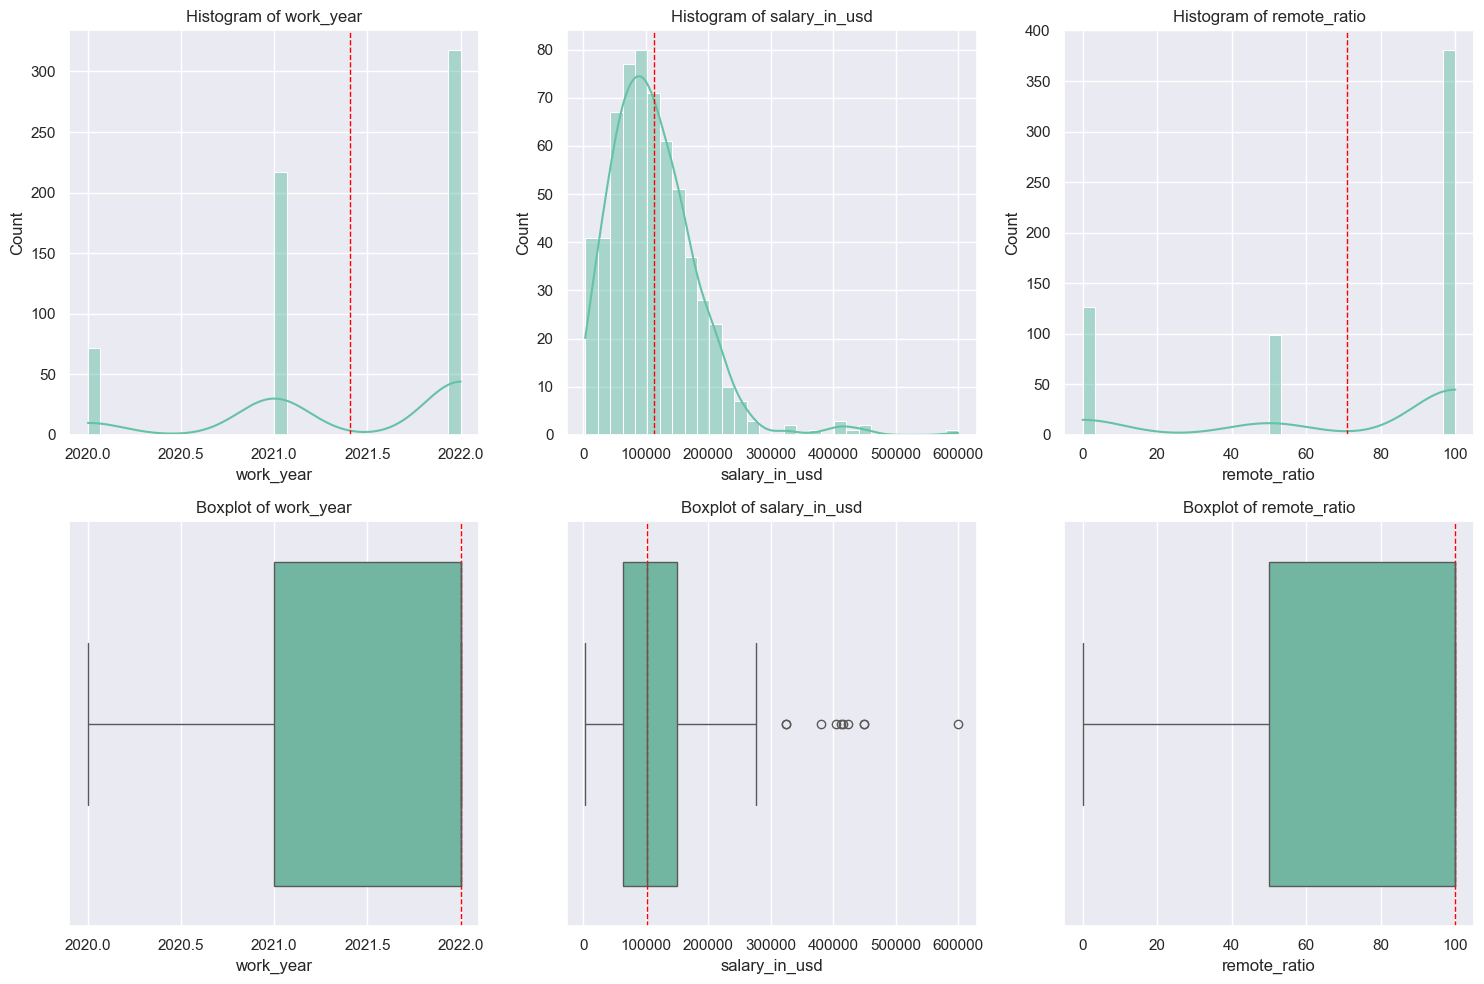

In [76]:
# list of numerical features
numerical_features = ["work_year", "salary_in_usd", "remote_ratio"]

# create histograms and boxplots
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    # histogram
    plt.subplot(2, len(numerical_features), i)
    sns.histplot(data[feature], kde=True, bins=30)
    plt.axvline(data[feature].mean(), color='red', linestyle='--', linewidth=1, label="Mean")
    plt.title(f"Histogram of {feature}")
    
    # boxplot
    plt.subplot(2, len(numerical_features), len(numerical_features) + i)
    sns.boxplot(x=data[feature])
    plt.axvline(data[feature].median(), color='red', linestyle='--', linewidth=1, label="Median")
    plt.title(f"Boxplot of {feature}")

plt.tight_layout()
plt.show()


As median and mean differ for the numeric features, we expect they are not distributed normally.

Now, we count and visualize categorical features. As "job_title_DS", "employee_residence", "company_location" have many unique values we will apply categorisation, putting rare values in the category "Other" for a better visualisation.

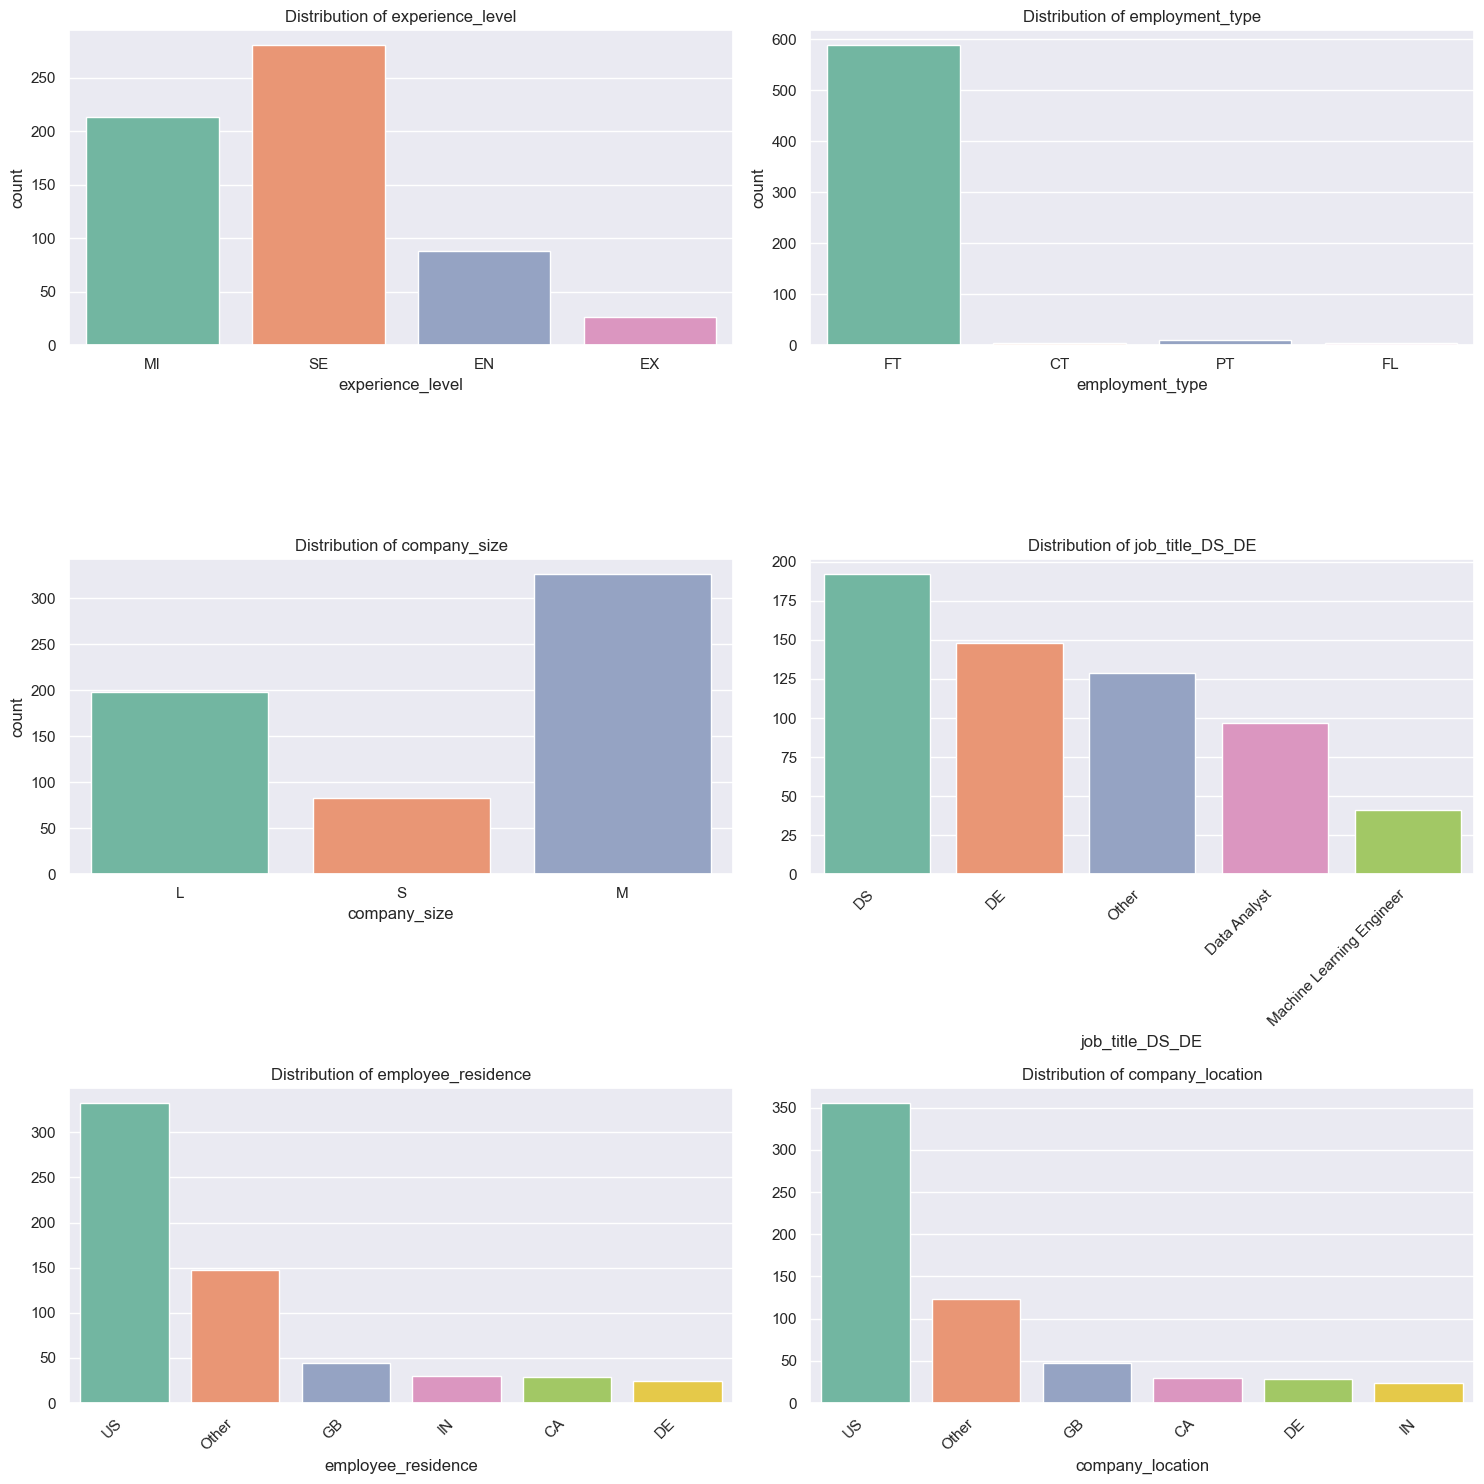

In [77]:
# function to group rare categories
def group_rare_categories(df, column, threshold=0.03):
    counts = df[column].value_counts(normalize=True)
    rare_categories = counts[counts < threshold].index
    df[column] = df[column].apply(lambda x: x if x not in rare_categories else 'Other')
    return df

# apply categorization for features with many unique values
categorical_features = ["job_title_DS_DE", "employee_residence", "company_location"]
for feature in categorical_features:
    data = group_rare_categories(data, feature)

# define all categorical features to visualize
all_categorical_features = ["experience_level", "employment_type", "company_size",
                            "job_title_DS_DE", "employee_residence", "company_location"]

# set up the figure with correct rows & columns
num_features = len(all_categorical_features)
rows = (num_features + 1) // 2  # in 3 rows, 2 columns
plt.figure(figsize=(15, rows * 5))  # dinamic height 

# loop through categorical features and plot
for i, feature in enumerate(all_categorical_features, 1):
    plt.subplot(rows, 2, i)
    
    if feature not in data.columns:
        continue  # skip missing columns
    
    if feature in ["job_title_DS_DE", "employee_residence", "company_location"]:
        sns.barplot(
            x=data[feature].value_counts().index, 
            y=data[feature].value_counts().values, 
            hue=data[feature].value_counts().index,  
            legend=False,
        )
        plt.xticks(rotation=45, ha='right')
    else:
        sns.countplot(data=data, x=feature, hue=feature)

    plt.title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()


Next we will visualise **the impact of different features on salary for Data Scientist positions**. 



Salary Data Scientist by Experience_level


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,28.0,58590.04,32115.87,4000.0,34920.0,55198.0,87527.25,110037.0
EX,11.0,196375.82,103378.46,69741.0,135936.0,167875.0,237000.00,416000.0
MI,69.0,87721.38,50552.68,2859.0,45760.0,82500.0,120000.00,241000.0
SE,84.0,154984.07,62201.17,20171.0,120120.0,147130.5,181275.00,412000.0



Salary Data Scientist by Employment_type


,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
CT,2.0,260500.00,219910.21,105000.0,182750.00,260500.0,338250.00,416000.0
FL,1.0,100000.00,NaN,100000.0,100000.00,100000.0,100000.00,100000.0
FT,187.0,118339.16,68597.93,2859.0,64634.50,117789.0,158600.00,412000.0
PT,2.0,60834.50,55388.38,21669.0,41251.75,60834.5,80417.25,100000.0



Salary Data Scientist by Company_size


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,71.0,121775.80,79795.90,13400.0,57128.00,115000.0,155333.50,412000.0
M,93.0,129193.49,57169.50,4000.0,91614.00,137141.0,165220.00,260000.0
S,28.0,78964.82,79917.35,2859.0,38030.75,66233.5,90309.25,416000.0



Salary Data Scientist by Employee_residence


,count,mean,std,min,25%,50%,75%,max
employee_residence,,,,,,,,
CA,8.0,101641.88,44851.57,52396.0,74164.5,93869.0,109573.5,196979.0
DE,15.0,99832.13,40432.36,49268.0,70332.0,88654.0,135936.0,173762.0
GB,13.0,87248.15,39531.34,39263.0,56256.0,76958.0,110037.0,183228.0
IN,13.0,31506.23,23948.38,5679.0,16904.0,29751.0,40481.0,94665.0
Other,39.0,59275.90,38826.49,2859.0,37234.0,48000.0,81342.0,168000.0
US,104.0,160633.73,63408.25,58000.0,120120.0,146500.0,186325.0,416000.0



Salary Data Scientist by Company_location


,count,mean,std,min,25%,50%,75%,max
company_location,,,,,,,,
CA,8.0,95921.62,47905.12,52396.0,65561.5,81756.0,109573.50,196979.0
DE,15.0,97436.47,43792.86,25532.0,70332.0,88654.0,135936.00,173762.0
GB,12.0,89999.00,39968.45,39263.0,63142.5,84286.0,111756.25,183228.0
IN,11.0,31800.73,23883.24,5707.0,17673.0,29751.0,37144.50,94665.0
Other,36.0,62152.97,42223.46,2859.0,37529.5,49823.0,85425.75,168000.0
US,110.0,154326.08,66826.51,5679.0,111250.0,140850.0,180000.00,416000.0



Salary Data Scientist by Work_year


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,28.0,102948.18,89203.03,5707.0,44869.25,78395.5,118500.0,412000.0
2021,74.0,96321.36,68976.06,2859.0,49734.50,88196.0,130019.5,416000.0
2022,90.0,142908.47,59498.13,18442.0,102750.50,140200.0,179250.0,380000.0



Salary Data Scientist by Remote_ratio


,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,49.0,110163.78,62581.24,2859.0,71982.0,104702.0,141300.0,250000.0
50,34.0,77350.97,42010.10,5707.0,50532.5,63278.5,106750.0,196979.0
100,109.0,136184.72,76540.78,5679.0,82500.0,140000.0,167875.0,416000.0


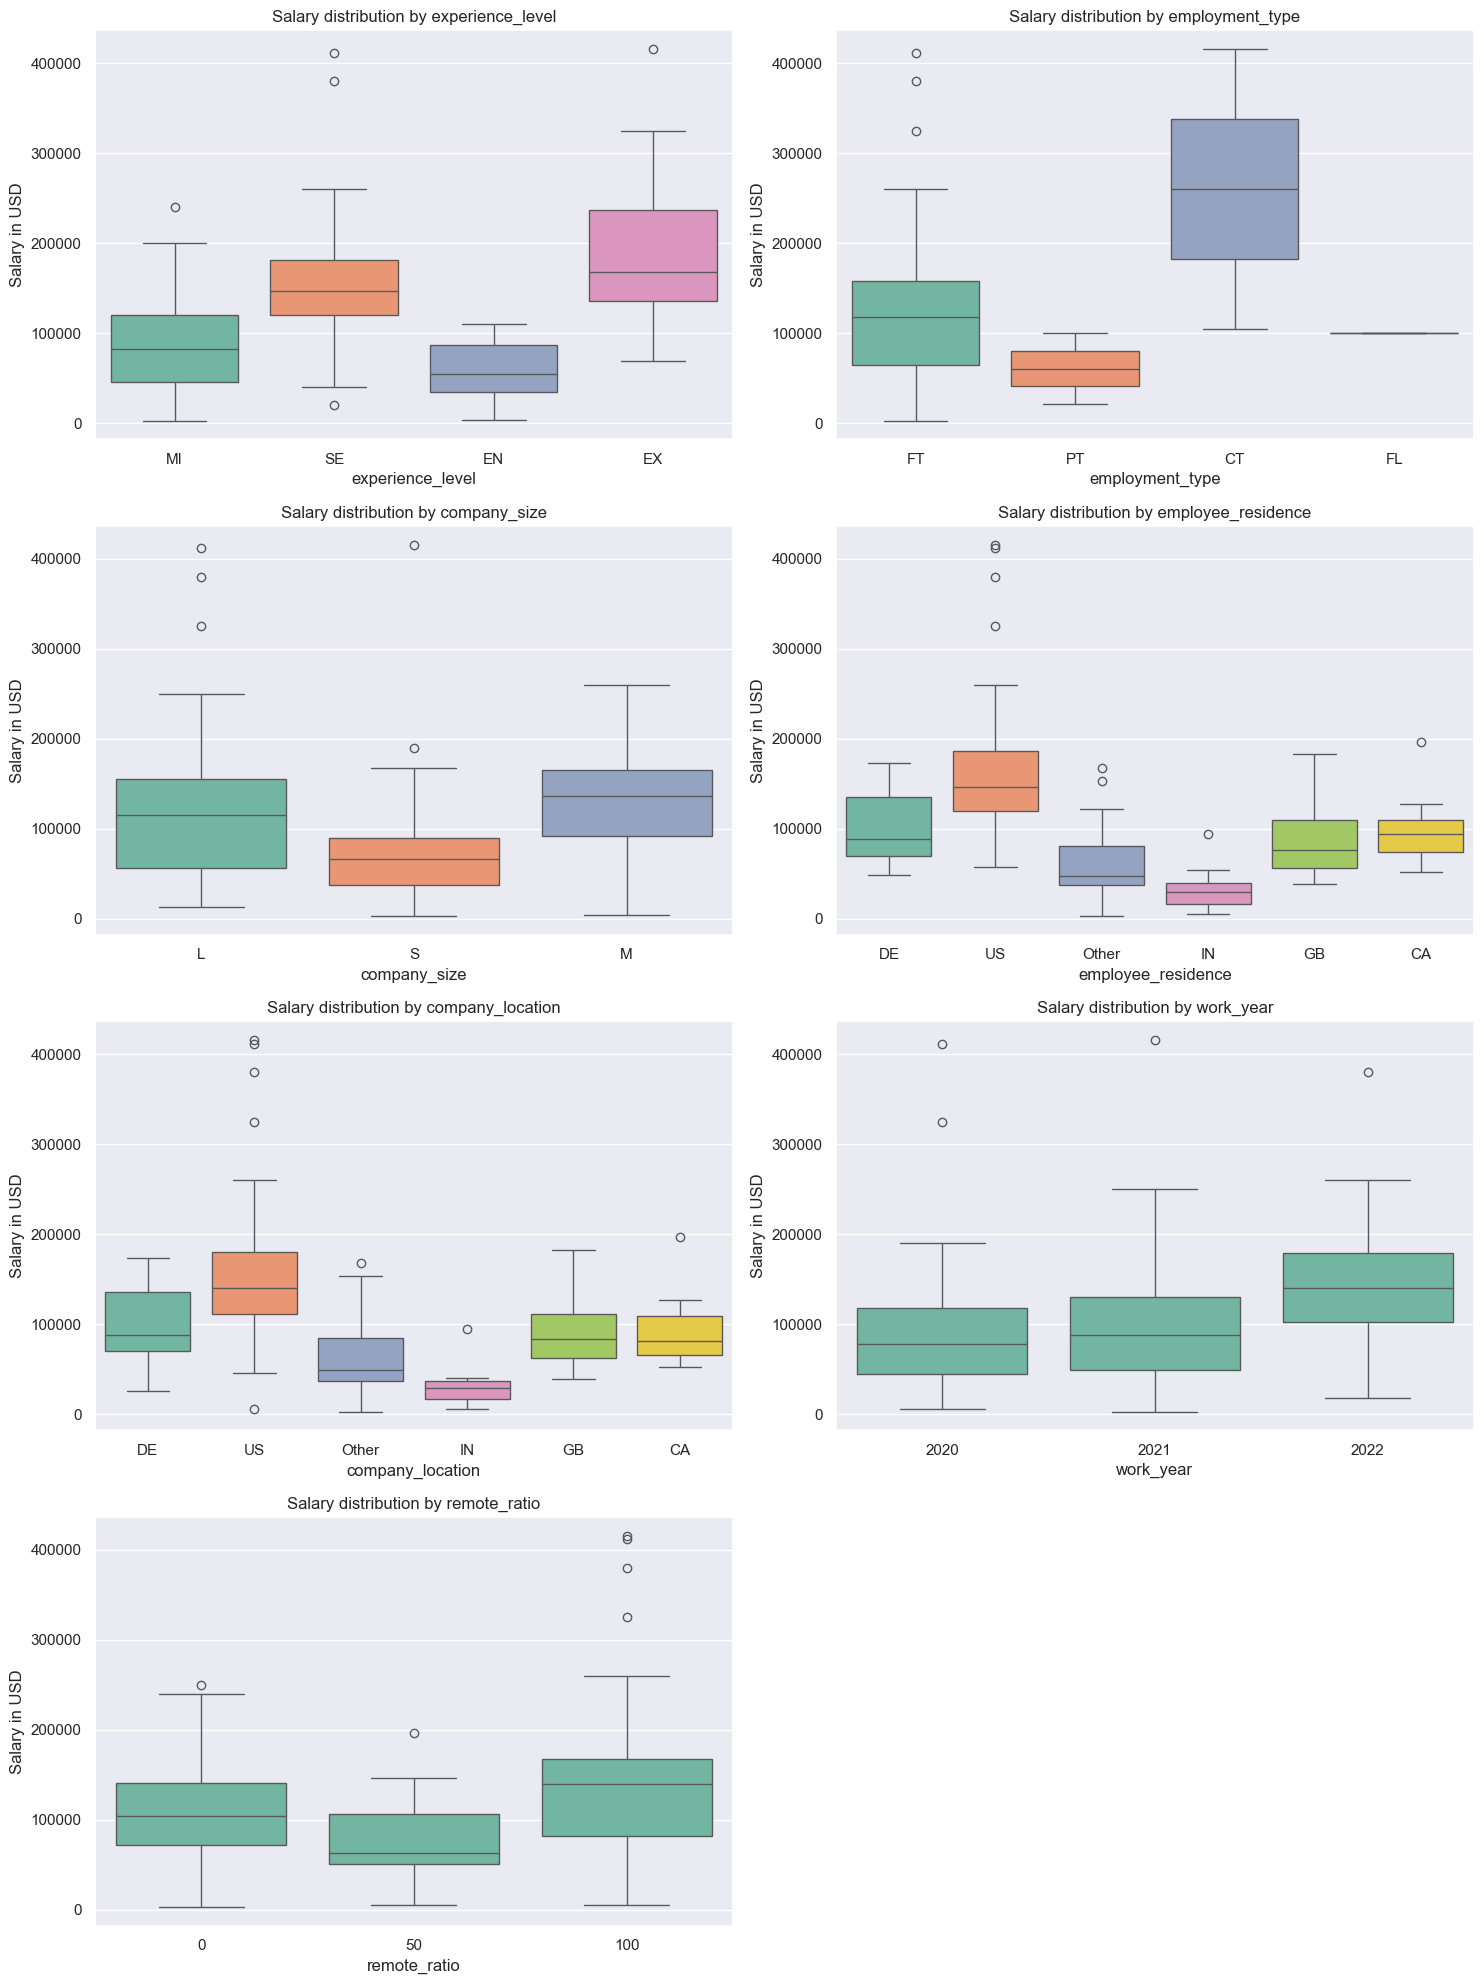

In [78]:
# filter DS jobs
data_scientists_data = data[data['job_title_DS_DE'] == "DS"]

# all features to be plotted
features = ["experience_level", "employment_type", "company_size", "employee_residence", "company_location", "work_year", "remote_ratio"]

# create the plots
plt.figure(figsize=(15, 20))

# plot the relationship between salary and all features
for i, feature in enumerate(features, 1):
    plt.subplot(4, 2, i)  # 4x2 grid for all features
    
    # check if feature is categorical
    if data_scientists_data[feature].dtype == 'object' or data_scientists_data[feature].dtype.name == 'category':
        # boxplot for categorical features, hue for categories
        sns.boxplot(x=data_scientists_data[feature], y=data_scientists_data["salary_in_usd"], 
                    hue=data_scientists_data[feature], palette="Set2")
    else:
        # boxplot for numerical features (no hue)
        sns.boxplot(x=data_scientists_data[feature], y=data_scientists_data["salary_in_usd"])
    
    plt.title(f"Salary distribution by {feature}")
    plt.xlabel(feature)
    plt.ylabel("Salary in USD")

    # statistics for the feature vs. salary
    print(f"\nSalary Data Scientist by {feature.capitalize()}")
    data_agg = data_scientists_data.groupby(feature)['salary_in_usd'].describe().round(2)
    display(data_agg)

plt.tight_layout()
plt.show()


### Data Scientist Salaries by Experience Level, Employment Type, Company Size, and Other Variables

#### Salaries vs. Experience Level

The salaries for Data Scientists seem to vary significantly depending on experience. For **entry-level positions (EN)**, the **average salary is $58,590**, with salaries **ranging from $4,000 to $110,037**. The **median salary is $55,198**, indicating that most entry-level professionals earn between $35,000 and $55,000.

For **mid-level professionals (MI)**, the **average salary is $87,721**, with a **range from $2,859 to $241,000**. The **median salary** for this group is **$82,500**, and most professionals in this category earn between $45,000 and $120,000.

At the **senior level (SE)**, Data Scientists are paid an **average of $154,984**, with a **range from $20,171 to $412,000**, and the **median salary is $147,130**. Senior Data Scientists typically earn between $120,000 and $180,000.

**Expert-level** Data Scientists (EX) have the highest salaries, with an **average of $196,376**, a **range from $69,741 to $416,000**, and a **median of $167,875**. Most professionals in this category earn between $135,000 and $237,000.

The salaries seem to progress with experience level, with the average almost 4 times higher for executive roles than at the entry level.

#### Salaries vs. Employment Type

**Contract (CT)** Data Scientists earn the highest **average salaries of $260,500**, ranging from **$105,000 to $416,000**. However, the contract category only includes two employees, so this data may be skewed by high earners.

**Freelance (FL)** Data Scientists earn an average of **$100,000**, with only one employee listed in this category.

For **Full-time (FT)** employees, the most common employment type, the **average salary is $118,339**, with a salary range from **$2,859 to $412,000**, and most employees earn between $64,000 and $158,000.

**Part-time (PT)** employees, a group of just two, earn an **average of $60,834**, with a salary range from **$21,669 to $100,000**.


#### Salaries by Company Size

The size of the company significantly impacts the salary of a Data Scientist. Employees at **large companies (L)** earn an **average of $121,775**, with salaries **ranging from $13,400 to $412,000**. Most employees at large companies earn between **$57,000 and $155,000**.

Data Scientists working at **medium-sized companies (M)** earn slightly more, with an **average salary of $129,193** snd the range from **$4,000 to $260,000**, where most employees earn between **$91,000 and $165,000**.

**Small companies (S)** offer a **mean salary of $78,964**, the lowest accross the categories. The range is wide, from **$2,859 to $416,000**, but most employees earn between **$38,000 and $90,000**.

#### Salaries by Employee Residence

**Canada (CA)** Data Scientists earn an **average salary of $101,642**, with salaries **ranging from $52,396 to $196,979**. Most Data Scientists in Canada earn between **$74,164 and $93,869**.

In **Germany (DE)**, the **average salary is $99,832**, with a salary range of **$49,268 to $173,762**. Most professionals in this region earn between **$70,332 and $88,654**.

For **Great Britain (GB)**, the **average salary is $87,248**, with a salary range from **$39,263 to $183,228**. Most employees earn between **$56,256 and $76,958**.

**India (IN)** offers a lower average salary of **$31,506**, with salaries ranging from **$5,679 to $94,665**. Most professionals in India earn between **$16,904 and $29,751**.

The **Other** category has an average salary of **$59,276**, with a range from **$2,859 to $168,000**, and most employees earn between **$37,234 and $48,000**.

In the **United States (US)**, Data Scientists earn an **average salary of $160,634**, with salaries ranging from **$58,000 to $416,000**. Most employees earn between **$120,120 and $146,500**.

The US residents earn the highest, followed by Canadiens, while Indian employess seem to earn the least.

#### Salaries by Company Location

Data Scientists in companies lacated **Canada (CA)** earn an **average of $95,922**, with salaries ranging from **$52,396 to $196,979**. Most employees in these companies earn between **$65,561 and $81,756**.

In **German companies (DE)**, the **average salary is $97,436**, with a salary range from **$25,532 to $173,762**. Most professionals earn between **$70,332 and $88,654**.

For **Great Britain (GB)**, the **average salary is $89,999**, with a salary range from **$39,263 to $183,228**. Most employees earn between **$63,142 and $84,286**.

In **Indian companies (IN)**, the **average salary is $31,801**, with a range from **$5,707 to $94,665**. Most employees earn between **$17,673 and $29,751**.

The **Other** category has an average salary of **$62,153**, with a salary range from **$2,859 to $168,000**, and most employees earn between **$37,529 and $49,823**.

In the **United States (US)**, companies pay Data Scientists an **average salary of $154,326**, with salaries ranging from **$5,679 to $416,000**. Most employees earn between **$111,250 and $140,850**.

Similarly to the employee residency, the company location that offer the highest salaries to Data Scientists is the US, and the lowest - India, however the second best salaries are in Germany, closely followed by Canada. 


#### Salaries by Work Year

In **2020**, Data Scientists earned an **average salary of $102,948**, with a salary range from **$5,707 to $412,000**. Most professionals earned between **$44,869 and $78,395**.

In **2021**, the **average salary was $96,321**, with salaries ranging from **$2,859 to $416,000**. Most Data Scientists earned between **$49,734 and $88,196**.

In **2022**, the **average salary increased to $142,908**, with a salary range from **$18,442 to $380,000**. Most employees earned between **$102,751 and $140,200**.

There seem to be a slight descrease in Data Scientists' average salaries in 2021, and a rapid increase in 2022. However the boxplots indicate an expected gradual salary growth. 

#### Salaries by Remote Ratio

For **Data Scientists with 0% remote work**, the **average salary is $110,164**, with a range from **$2,859 to $250,000**. Most employees earned between **$71,982 and $104,702**.

In the **50% remote work** category, the **average salary is $77,351**, with a salary range from **$5,707 to $196,979**. Most professionals earned between **$50,533 and $63,279**.

For **100% remote work**, Data Scientists earn an **average salary of $136,185**, with a salary range from **$5,679 to $416,000**. Most employees earned between **$82,500 and $140,000**.

#### Overall analysis

* There are **substantial salary differences across different regions** (e.g., US, Canada, India), which suggest  a strong geographical influence on Data Scientist salaries, likely due to varying economic conditions, industry demand, and cost of living.

* Work year data (2020, 2021, 2022) imply **salary growth over time**, with 2022 presenting a significant increase in average salaries. 

* The **100% remote Data Scientists appear to earn the highest salaries**.

* The visual analysis shows that the data contains  **outliers accross the features and categories**, especially in categories with small sample sizes (e.g., Contract (CT), Freelance (FL), Part-time (PT), and certain locations like India), that need to be dealt with in the further analysis. 

* All of the listed features, namely Experience Level, Employment Type, Company Size, Employee Residence, Company Location, and Remote Ratio, seem to impact the Data Scientist salaries, however **the observed differences should be tested for statistical significance**. 


## Statistical Data Analysis

In [79]:
# define funcion to check normality of the distribution
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-value is less than {:.2f}. The data is not distributed normally'.format(alpha))
    else:
        print('p-value is greater than {:.2f}. The data is distributed normally'.format(alpha))


# define function for making a decision about rejecting the null hypothesis
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-value is less than the given significance level {:.2f}. Reject the null hypothesis.'.format(alpha))
    else:
        print('p-value is greater than the given significance level  {:.2f}. No indications to reject the null hypothesis.'.format(alpha))
      

### Research question 1: Is there an annual salary increase for Data Scientists?

Exploratory data analysis seems to indicate that there was a significant growth in Data Scientist salary over the observed period (2020-2022).

**Formulate the null and alternative hypotheses**

*Null hypothesis* ($H_0$): The average Data Scientist salary from 2020 to 2022 ($μ_1$) statistically decreased or remained the same.

$$ H_0 : μ_1 \text{ (2022)} <= μ_1 \text{ (2020)} $$

*Alternative hypothesis* ($H_1$): The average Data Scientist salary from 2020 to 2022 ($μ_1$) statistically increased.

$$ H_1 : μ_1 \text{ (2022)} > μ_1 \text{ (2020)} $$


**Normality Test**

We will use the **Shapiro-Wilk test** to check whether the feature follows a normal distribution:

Null Hypothesis ($H_0$): The data distribution is normal.

Alternative Hypothesis ($H_1$): The data distribution is different from normal.

**Note:** We will use the same test with the same null- and alternative hypothesis for the following normality tests in the study.

In [80]:
# filter data by year
data_2020 = data.loc[data['work_year'] == 2020,'salary_in_usd']
data_2021 = data.loc[data['work_year'] == 2021,'salary_in_usd']
data_2022 = data.loc[data['work_year'] == 2022,'salary_in_usd']

# Print the length of the filtered data
# print(f"Length of data_2020: {len(data_2020)}")
# print(f"Length of data_2021: {len(data_2021)}")
# print(f"Length of data_2023: {len(data_2022)}")

# Shapiro-Wilk test for each year with the decision function
print('For 2020:')
result_2020 = stats.shapiro(data_2020)
decision_normality(result_2020[1])

print('\nFor 2021:')
result_2021 = stats.shapiro(data_2021)
decision_normality(result_2021[1])

print('\nFor 2022:')
result_2022 = stats.shapiro(data_2022)
decision_normality(result_2022[1])


For 2020:
p-value = 0.000
p-value is less than 0.05. The data is not distributed normally

For 2021:
p-value = 0.000
p-value is less than 0.05. The data is not distributed normally

For 2022:
p-value = 0.000
p-value is less than 0.05. The data is not distributed normally


**Choosing the appropriate statistical test**

To select the right test, we will use the followingdecision-making algorithm:
* What type of variable is "Salary_in_USD"? — Quantitative.
* How many groups are we comparing? — Three (2020, 2021, and 2022 years).
* Are the groups dependent? — No.
* Is the variable normally distributed? — No (based on the Shapiro-Wilk test results).

As the data is not normally distributed, we will use a non-parametric test **Kruskal-Wallis H** to compare the salaries across the three years. 


In [81]:
# perform the Kruskal-Wallis H test and use the decision function
_, p = stats.kruskal(data_2020, data_2021, data_2022)
decision_hypothesis(p)

p-value = 0.000
p-value is less than the given significance level 0.05. Reject the null hypothesis.


**Conclusion**

Since the null hypothesis was rejected, the alternative hypothesis is correct. Therefore, **there was a statistically significant growth in Data Scientist salaries over the observed period** (2020, 2021, and 2022).

### Research question 2: How do Data Scientist and Data Engineer salaries compare in 2022?

**Formulate the null and alternative hypotheses**

**Null hypothesis** ($H_0$): There is no difference in the average salaries between Data Scientists and Data Engineers in 2022.

$$ H_0: μ_{DS} (2022) = μ_{DE} (2022) $$

Where:
- $μ_{DS}$ is the average salary of Data Scientists in 2022.
- $μ_{DE}$ is the average salary of Data Engineers in 2022.

**Alternative hypothesis** ($H_1$): The average salary of Data Scientists in 2022 is different from (greater or lesser than) that of Data Engineers.

$$ H_1: μ_{DS} (2022) ≠ μ_{DE} (2022) $$

Where:
- $μ_{DS}$ is the average salary of Data Scientists in 2022.
- $μ_{DE}$ is the average salary of Data Engineers in 2022.

Fisrt, we will get the boxplot and the discriptive statistics for the salaries in both groups in 2002, to estimate if there was any difference between the groups.

,count,mean,std,min,25%,50%,75%,max
job_title_DS_DE,,,,,,,,
DE,90.0,126284.711111,55645.855116,25000.0,78894.5,119093.5,160000.0,324000.0
DS,90.0,142908.466667,59498.133287,18442.0,102750.5,140200.0,179250.0,380000.0


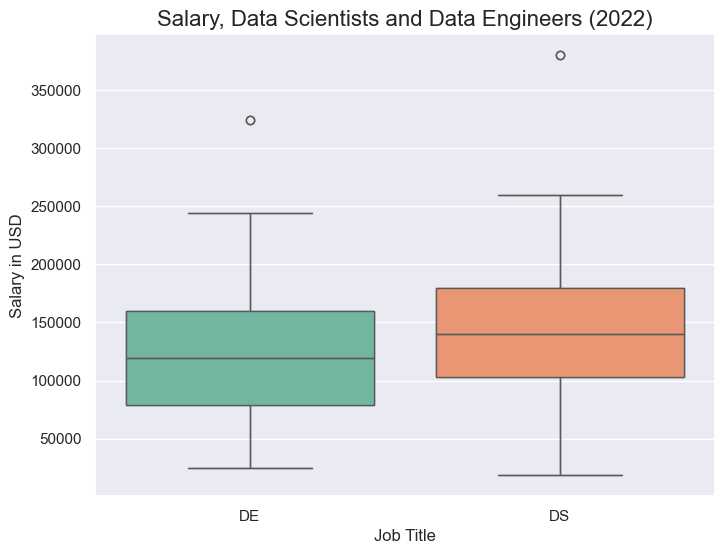

In [82]:
# filter year 2022
data_2022 = data[data['work_year'] == 2022]

# filter the data for Data Scientists and Data Engineers
data_2022_ds_de = data_2022[data_2022['job_title_DS_DE'].isin(['DS', 'DE'])]

# get descriptive statistics for salaries of DS and DE in 2022
salary_description = data_2022_ds_de.groupby('job_title_DS_DE')['salary_in_usd'].describe()
display(salary_description)

# plot a figure for visualization
plt.figure(figsize=(8, 6))

# create a set for visualisation 
sns.boxplot(x='job_title_DS_DE', y='salary_in_usd', data=data_2022_ds_de)

# boxplot to compare the salary distribution between the two roles
sns.boxplot(x='job_title_DS_DE', y='salary_in_usd', data=data_2022_ds_de, hue='job_title_DS_DE')

plt.title('Salary, Data Scientists and Data Engineers (2022)', fontsize=16)
plt.xlabel('Job Title', fontsize=12)
plt.ylabel('Salary in USD', fontsize=12)


plt.show()


The boxplot reveals that in 2022, Data Scientists earned higher salaries compared to Data Engineers, with the **average salary for Data Scientists slightly above $126,000**, while **Data Engineers' average salary was just under $142,000.**

We will now proceed to check the apparent difference for statistical significance. First we will run the normality test on the relevant data to determine the appropriate statistical test.

In [83]:
# filter the dataset for Data Scientist and Data Engineer salaries in 2022
ds_2022 = data.loc[(data['work_year'] == 2022) & (data['job_title_DS_DE'] == 'DS'), 'salary_in_usd']
de_2022 = data.loc[(data['work_year'] == 2022) & (data['job_title_DS_DE'] == 'DE'), 'salary_in_usd']

# print the length of the filtered data
# print(f"Length of ds_2022: {len(ds_2022)}")
# print(f"Length of de_2022: {len(de_2022)}")

# Shapiro-Wilk test for normality with the decision function
print('For Data Scientists (2022):')
result_ds_2022 = stats.shapiro(ds_2022)
decision_normality(result_ds_2022[1])

print('\nFor Data Engineers (2022):')
result_de_2022 = stats.shapiro(de_2022)
decision_normality(result_de_2022[1])


For Data Scientists (2022):
p-value = 0.023
p-value is less than 0.05. The data is not distributed normally

For Data Engineers (2022):
p-value = 0.010
p-value is less than 0.05. The data is not distributed normally


Since the data is not normally distributed, the appropriate non-parametric test to compare the salaries of Data Scientists and Data Engineers in 2022 is **the Mann-Whitney U test**, as it is designed to compare two independent groups, with a single measure.

In [84]:
# Mann-Whitney U test for Data Scientists and Data Engineers salaries in 2022
_, p_value = stats.mannwhitneyu(ds_2022, de_2022, alternative='two-sided')

# the decision function to interpret the result
decision_hypothesis(p_value)

p-value = 0.031
p-value is less than the given significance level 0.05. Reject the null hypothesis.


**Conclusion**

Since the p-value is less than the given significance level (0.05), we **reject the null hypothesis**. This means that there is a statistically significant difference in the salaries of Data Scientists and Data Engineers in 2022. It gives **sufficient evidence that in 2022 Data Scientists were paid higher salaries than Data Engineers.** 

**Note:** Based on available data from open sources, Data Engineers (DE) generally earned slightly higher average salaries than Data Scientists (DS) in 2022. The salary figures we compared might not fully reflect the scope of roles or industry, so the results musst be taken with caution.

### Research question 3: * How do Data Scientist salaries vary across companies of different sizes?

### **Formulate the Null and Alternative Hypotheses**

**Null hypothesis** ($H_0$): There is no difference in the average salaries of Data Scientists across companies of different sizes in 2022.

$$ H_0: μ_{small} = μ_{medium} = μ_{large} $$

Where:
- $μ_{small}$ is the average salary of Data Scientists working in small companies.
- $μ_{medium}$ is the average salary of Data Scientists working in medium-sized companies.
- $μ_{large}$ is the average salary of Data Scientists working in large companies.

**Alternative hypothesis** ($H_1$): There is a difference in the average salaries of Data Scientists across companies of different sizes in 2022.

$$ H_1: μ_{small} ≠ μ_{medium} ≠ μ_{large} $$

Where:
- $μ_{small}$ is the average salary of Data Scientists working in small companies.
- $μ_{medium}$ is the average salary of Data Scientists working in medium-sized companies.
- $μ_{large}$ is the average salary of Data Scientists working in large companies.

As we saw in the Discriptive Data Analysis, the company size is a factor that affects salaries in the IT industry, with the highest pay offered by medium-sized employers, and the lowest - by small companies. Now we will visualise the data for Data Scientists only and get the discriptive statistics to see if they suggest any influence a company size on the Data Scientists salaries.

Descriptive Statistics for Small Companies:
count        28.000000
mean      78964.821429
std       79917.348509
min        2859.000000
25%       38030.750000
50%       66233.500000
75%       90309.250000
max      416000.000000
Name: salary_in_usd, dtype: float64

Descriptive Statistics for Medium Companies:
count        93.000000
mean     129193.494624
std       57169.502055
min        4000.000000
25%       91614.000000
50%      137141.000000
75%      165220.000000
max      260000.000000
Name: salary_in_usd, dtype: float64

Descriptive Statistics for Large Companies:
count        71.000000
mean     121775.802817
std       79795.901201
min       13400.000000
25%       57128.000000
50%      115000.000000
75%      155333.500000
max      412000.000000
Name: salary_in_usd, dtype: float64


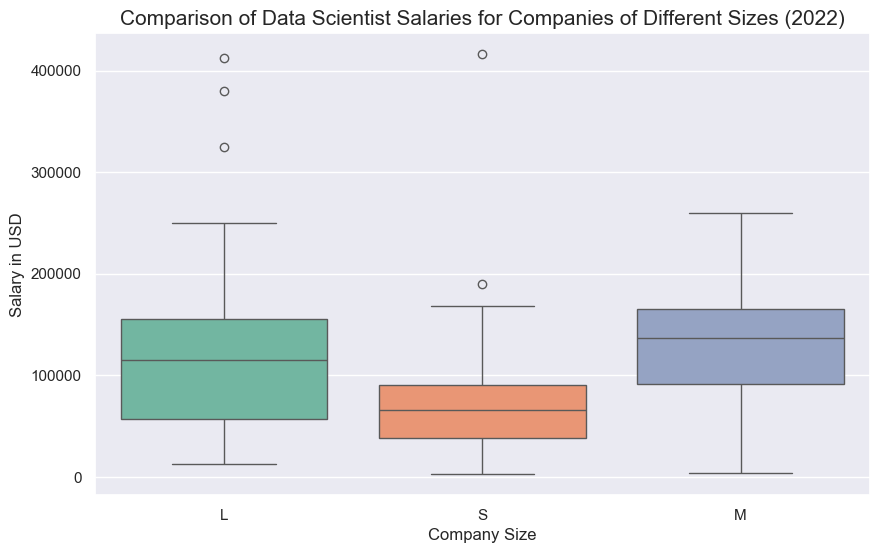

In [85]:
# filter the data for Data Scientists
data_ds = data[data['job_title_DS_DE'] == 'DS']

# filter the data by company size
data_small = data_ds[data_ds['company_size'] == 'S']
data_medium = data_ds[data_ds['company_size'] == 'M']
data_large = data_ds[data_ds['company_size'] == 'L']

# get discriptive satistics the data for each company size group
print("Descriptive Statistics for Small Companies:")
print(data_small['salary_in_usd'].describe())

print("\nDescriptive Statistics for Medium Companies:")
print(data_medium['salary_in_usd'].describe())

print("\nDescriptive Statistics for Large Companies:")
print(data_large['salary_in_usd'].describe())

# a DataFrame to use in a boxplot
data_combined = data_ds[data_ds['company_size'].isin(['S', 'M', 'L'])]

# boxplot to compare the salaries by company size
plt.figure(figsize=(10, 6))
sns.boxplot(x='company_size', y='salary_in_usd', data=data_combined, hue='company_size')
plt.title('Comparison of Data Scientist Salaries for Companies of Different Sizes (2022)', fontsize=15)
plt.xlabel('Company Size', fontsize=12)
plt.ylabel('Salary in USD', fontsize=12)
plt.show()


Visual analysis suggests, that the that salaries vary significantly with highest salaries  paid to Data Scientists in medium-sized companies, and the lowest - in small companies. However, based  on the descriptive statistics above, **Data Scientists in small companies** have an average salary of **$78,965**. **In medium-sized companies**, Data Scientists earn an average salary of **$129,193**, and  **Large companies** pay an average salary of **$121,776** Overall, the data suggests that **Data Scientists in medium and large companies tend to have higher and more consistent salaries** compared to those in small companies as the median values for these two groups fall closer to the mean values.

Next, we will assess the normality of the data distribution and choose an appropriate statistical test to determine whether the differences are statistically significant.

In [86]:
# the Shapiro-Wilk test for normality on filtered data
print("Normality Test for Small Companies:")
result_small = stats.shapiro(data_small['salary_in_usd'])
decision_normality(result_small[1])

print("\nNormality Test for Medium Companies:")
result_medium = stats.shapiro(data_medium['salary_in_usd'])
decision_normality(result_medium[1])

print("\nNormality Test for Large Companies:")
result_large = stats.shapiro(data_large['salary_in_usd'])
decision_normality(result_large[1])

Normality Test for Small Companies:
p-value = 0.000
p-value is less than 0.05. The data is not distributed normally

Normality Test for Medium Companies:
p-value = 0.565
p-value is greater than 0.05. The data is distributed normally

Normality Test for Large Companies:
p-value = 0.000
p-value is less than 0.05. The data is not distributed normally


Since the data isn't normally distributed we need to use a non-parametric test to compare the salaries across the different company sizes. We will do the **Kruskal-Wallis H test**, as it is designed to compare more than two independent groups (a non-parametric version of one-way ANOVA)

In [87]:
# Kruskal-Wallis H test
_, p = stats.kruskal(data_small['salary_in_usd'], data_medium['salary_in_usd'], data_large['salary_in_usd'])
decision_hypothesis(p)

p-value = 0.000
p-value is less than the given significance level 0.05. Reject the null hypothesis.


**Conclusion**

We can reject the null hypothesis based on the p-value being less than the significance level (0.05), this indicates that **there is a statistically significant difference in the salaries of Data Scientists across companies of different sizes, with medium and large companies offereng a higher pay to Data Scientists than the small ones.**

### Research question 4: Is there a correlation between the presence of Data Scientist and Data Engineer roles and company size?

**Formulating the Null and Alternative Hypotheses**

**Null Hypothesis** ($H_0$): There is no relationship between job role (Data Scientist or Data Engineer) and company size (the two variables are independent).

**Alternative Hypothesis** ($H_1$): There is a relationship between job role (Data Scientist or Data Engineer) and company size (the two variables are dependent).

To adress this question, we will begin with creating a **contigency table** for Data Scientists and Data Engineers across three company sizes.

In [88]:
# filter data for DS and DE roles 
data_ds_de = data[data['job_title_DS_DE'].isin(['DS', 'DE'])]

# create a contingency table of job roles (DS, DE) for company sizes S, M and L
contingency_table = pd.crosstab(data_ds_de['company_size'], data_ds_de['job_title_DS_DE'])

display(contingency_table)


job_title_DS_DE,DE,DS
company_size,,
L,45,71
M,92,93
S,11,28


Now, we will visualise the relevant data using a heatmap to observe a possible relationship between the presence of Data Scientists and Data Engineers in the company and its size.

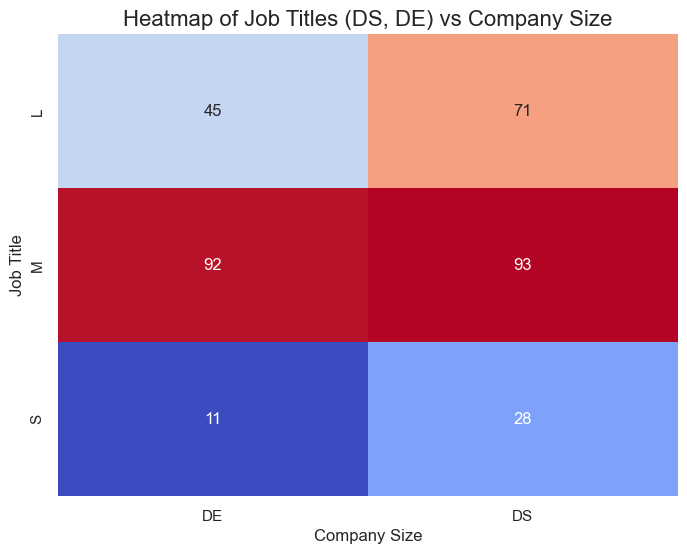

In [89]:
# create a heatmap of the contingency table
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='d', cbar=False)

# labels and title
plt.title("Heatmap of Job Titles (DS, DE) vs Company Size", fontsize=16)
plt.xlabel("Company Size", fontsize=12)
plt.ylabel("Job Title", fontsize=12)

plt.show()

The cross-table shows that in **large companies**, Data Scientists (**71**) outnumber Data Engineers (**45**), so there are more Data Scientists. In **medium-sized companies**, the numbers are almost equal, with Data Scientists (**93**) and Data Engineers (**92**). In **small companies**, Data Scientists (**28**) are more common than Data Engineers (**11**), but both roles are fewer overall.

Next, we will check if the differences are statistically significant.

**Choosing the Appropriate Statistical Test**  

To determine the appropriate test, we follow a decision-making process by answering the following questions:  
* What type of variable is "Job Role" (Data Scientist or Data Engineer)? — Categorical.  
* How many groups are being compared? — Two.  
* Are we testing for independence between the groups? — Yes.  

To test our hypothesis, we can use the **Chi-Square ($\chi^2$) test**.  

In [90]:
# perform the Chi-Square test
_, p, _, _ = chi2_contingency(contingency_table)
decision_hypothesis(p)

p-value = 0.022
p-value is less than the given significance level 0.05. Reject the null hypothesis.


**Conclusion**

Since p value is less than significance level (0.05), we reject the null hypothesis, meaning **company size and job role (DS vs. DE) are correlated.**


### Research question 5: What are key factors influencing the salaries of Data Scientists**. 

As we have seen above, Work Year and Company Size have statistically significant effect on Data Scientists salaries. The visual analysis suggest that the salaries might also be affected by other variables, namely: Experience Level, Employment Type, Company Location, Employee Residency, and Remote Ratio.

We will now check if the effect these factors have is statistically significant.

**Formulate Hypotheses**

For each factor (Experience Level, Employment Type, Company Location, Employee Residency, and Remote Ratio), we will assume:

**Null hypothesis** ($H_0$): There is no significant difference in the salaries of Data Scientists across the categories of this factor.

**Alternative hypothesis** ($H_1$): There is a significant difference in the salaries of Data Scientists across the categories of this factor.


#### 5.1 Experience Level vs. Data Scientists Salaries

In [91]:
# experience level (entry, mid, senior)

# filter the salary data for each Experience Level category
entry_level_salaries = data_ds[data_ds['experience_level'] == 'EN']['salary_in_usd']
mid_level_salaries = data_ds[data_ds['experience_level'] == 'MI']['salary_in_usd']
senior_level_salaries = data_ds[data_ds['experience_level'] == 'SE']['salary_in_usd']
executive_level_salaries = data_ds[data_ds['experience_level'] == 'EX']['salary_in_usd']

# normality tests for each category
print("Shapiro-Wilk test for Experience Level (Entry Level):")
_, p = stats.shapiro(entry_level_salaries)
decision_normality(p)

print("\nShapiro-Wilk test for Experience Level (Mid Level):")
_, p = stats.shapiro(mid_level_salaries)
decision_normality(p)

print("\nShapiro-Wilk test for Experience Level (Senior Level):")
_, p = stats.shapiro(senior_level_salaries)
decision_normality(p)

print("\nShapiro-Wilk test for Experience Level (Senior Level):")
_, p = stats.shapiro(executive_level_salaries)
decision_normality(p)

Shapiro-Wilk test for Experience Level (Entry Level):
p-value = 0.252
p-value is greater than 0.05. The data is distributed normally

Shapiro-Wilk test for Experience Level (Mid Level):
p-value = 0.081
p-value is greater than 0.05. The data is distributed normally

Shapiro-Wilk test for Experience Level (Senior Level):
p-value = 0.000
p-value is less than 0.05. The data is not distributed normally

Shapiro-Wilk test for Experience Level (Senior Level):
p-value = 0.418
p-value is greater than 0.05. The data is distributed normally


Since the data in one of the categories is not normally distributed, we will choose a non-parametric test **Kruskal-Walli**s to compare salary distributions.

In [92]:
_, p_value = stats.kruskal(entry_level_salaries, mid_level_salaries, senior_level_salaries, executive_level_salaries)
decision_hypothesis(p)

p-value = 0.418
p-value is greater than the given significance level  0.05. No indications to reject the null hypothesis.


The non-parametric test showed there is no statistically significant effect of Experience Level on Data Scientists salary. As the result us unexpected, we will try and re-check the statistical significance of the differences in salaries using the **ANOVA tests for the categories with normally distributed data.**

In [93]:
_, p_value = stats.f_oneway(entry_level_salaries, mid_level_salaries, executive_level_salaries)
decision_hypothesis(p)

p-value = 0.418
p-value is greater than the given significance level  0.05. No indications to reject the null hypothesis.


😢  CAN'T BE TRUE. I RESIGN AND GO INTO FLORISTICS.

The ANOVA test also suggests no statistically significant differences in Data Scientists salaries for different experience levels.

**Conclusion**

Although both ANOVA and Kruskal-Wallis tests showed no statistically significant differences in Data Scientist salaries across experience levels, the visualizations, the descriptive statistics and common sense suggest there might be differences. **This desparity might be due small sample sizes in some experience categories, or outliers affecting the tests' power**. 

#### 5.2 Experience Level vs. Data Scientists Salary

Since the dataset includes only one freelance, two contract, and two part-time Data Scientists, it is not possible to perform normality tests for these categories. As a result, we are left with only full-time employees for analysis. Given the limited data for the other employment types, **we cannot assess the statistical significance of the salary differences across the various employment types for Data Scientists.**

#### 5.3 Employee Residence vs. Data Scientists Salary

First we will take another look at the values of the employee residence feature, as they are after we encoded the less frequent location as "Other".

In [94]:
data_ds['employee_residence'].value_counts()

employee_residence
US       104
Other     39
DE        15
IN        13
GB        13
CA         8
Name: count, dtype: int64

We will carry out the **Shapiro-Wilk normality test** for each category.

In [95]:
# filter salary data by Employee Residence
us_salaries = data_ds[data_ds['employee_residence'] == 'US']['salary_in_usd']
other_salaries = data_ds[data_ds['employee_residence'] == 'Other']['salary_in_usd']
de_salaries = data_ds[data_ds['employee_residence'] == 'DE']['salary_in_usd']
in_salaries = data_ds[data_ds['employee_residence'] == 'IN']['salary_in_usd']
gb_salaries = data_ds[data_ds['employee_residence'] == 'GB']['salary_in_usd']
ca_salaries = data_ds[data_ds['employee_residence'] == 'CA']['salary_in_usd']

# Shapiro-Wilk test for each category
print("Shapiro-Wilk test for Employee Residence (US):")
_, p = stats.shapiro(us_salaries)
decision_normality(p)

print("\nShapiro-Wilk test for Employee Residence (Other):")
_, p = stats.shapiro(other_salaries)
decision_normality(p)

print("\nShapiro-Wilk test for Employee Residence (DE):")
_, p = stats.shapiro(de_salaries)
decision_normality(p)

print("\nShapiro-Wilk test for Employee Residence (IN):")
_, p = stats.shapiro(in_salaries)
decision_normality(p)

print("\nShapiro-Wilk test for Employee Residence (GB):")
_, p = stats.shapiro(gb_salaries)
decision_normality(p)

print("\nShapiro-Wilk test for Employee Residence (CA):")
_, p = stats.shapiro(ca_salaries)
decision_normality(p)


Shapiro-Wilk test for Employee Residence (US):
p-value = 0.000
p-value is less than 0.05. The data is not distributed normally

Shapiro-Wilk test for Employee Residence (Other):
p-value = 0.007
p-value is less than 0.05. The data is not distributed normally

Shapiro-Wilk test for Employee Residence (DE):
p-value = 0.060
p-value is greater than 0.05. The data is distributed normally

Shapiro-Wilk test for Employee Residence (IN):
p-value = 0.045
p-value is less than 0.05. The data is not distributed normally

Shapiro-Wilk test for Employee Residence (GB):
p-value = 0.193
p-value is greater than 0.05. The data is distributed normally

Shapiro-Wilk test for Employee Residence (CA):
p-value = 0.192
p-value is greater than 0.05. The data is distributed normally


The salary data is not distributed normally for US, Other, India, so for the further statistical analysis we will use **the Kruskal-Wallis test.**

In [96]:
# Kruskal-Wallis test
_, p = stats.kruskal(us_salaries, other_salaries, de_salaries, in_salaries, gb_salaries, ca_salaries)
decision_hypothesis(p)


p-value = 0.000
p-value is less than the given significance level 0.05. Reject the null hypothesis.


**Conclusion**

The Kruskal-Wallis test results indicate that the alternative hypothesis holds true, thus **there is a statistically significant effect of Employee Residence on Data Scientists salaries, with the US residents earning the most, followed by Canadiens, while Indian employess earn the least.**

#### 5.4 Remote Ratio vs. Data Scientists Salary

We will begin with testing the data for the normality of distribution.

In [97]:
# filter salary data by Remote Ratio
remote_0_salaries = data_ds[data_ds['remote_ratio'] == 0]['salary_in_usd']
remote_50_salaries = data_ds[data_ds['remote_ratio'] == 50]['salary_in_usd']
remote_100_salaries = data_ds[data_ds['remote_ratio'] == 100]['salary_in_usd']

# Shapiro-Wilk test for each category
print("Shapiro-Wilk test for Remote Ratio (0):")
_, p = stats.shapiro(remote_0_salaries)
decision_normality(p)

print("Shapiro-Wilk test for Remote Ratio (50):")
_, p = stats.shapiro(remote_50_salaries)
decision_normality(p)

print("Shapiro-Wilk test for Remote Ratio (100):")
_, p = stats.shapiro(remote_100_salaries)
decision_normality(p)

Shapiro-Wilk test for Remote Ratio (0):
p-value = 0.372
p-value is greater than 0.05. The data is distributed normally
Shapiro-Wilk test for Remote Ratio (50):
p-value = 0.257
p-value is greater than 0.05. The data is distributed normally
Shapiro-Wilk test for Remote Ratio (100):
p-value = 0.000
p-value is less than 0.05. The data is not distributed normally


As the data for 100% remote work is not normaly distributed, we will now try and **normalise the data distribution using the log-transformation**. It works best for the data skewed right (no 0 or negative values), so we will first perform a simple test to see if our data fits the transformation.

In [98]:
print((data_ds['salary_in_usd'] <= 0).sum())  # Count of zero/negative salaries


0


The data is right-skewed, so we will apply the log-transformation.

In [99]:
# create a new column for square root-transformed salaries
data_ds['salary_in_usd_log'] = data_ds['salary_in_usd']

# log-transformation only to the 100% remote category
data_ds.loc[data_ds['remote_ratio'] == 100, 'salary_in_usd_log'] = np.log(
    data_ds.loc[data_ds['remote_ratio'] == 100, 'salary_in_usd']
)

# filter salary data by Remote Ratio
remote_0_salaries = data_ds[data_ds['remote_ratio'] == 0]['salary_in_usd_log']
remote_50_salaries = data_ds[data_ds['remote_ratio'] == 50]['salary_in_usd_log']
remote_100_salaries = data_ds[data_ds['remote_ratio'] == 100]['salary_in_usd_log']

# Shapiro-Wilk test for each category
print("Shapiro-Wilk test for Remote Ratio (0):")
_, p = stats.shapiro(remote_0_salaries)
decision_normality(p)

print("\nShapiro-Wilk test for Remote Ratio (50):")
_, p = stats.shapiro(remote_50_salaries)
decision_normality(p)

print("\nShapiro-Wilk test for Remote Ratio (100):")
_, p = stats.shapiro(remote_100_salaries)
decision_normality(p)


Shapiro-Wilk test for Remote Ratio (0):
p-value = 0.372
p-value is greater than 0.05. The data is distributed normally

Shapiro-Wilk test for Remote Ratio (50):
p-value = 0.257
p-value is greater than 0.05. The data is distributed normally

Shapiro-Wilk test for Remote Ratio (100):
p-value = 0.000
p-value is less than 0.05. The data is not distributed normally


/var/folders/sf/83dwp_ds2sdd7m59tbgj21kr0000gn/T/ipykernel_54598/1020784166.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ds['salary_in_usd_log'] = data_ds['salary_in_usd']
/var/folders/sf/83dwp_ds2sdd7m59tbgj21kr0000gn/T/ipykernel_54598/1020784166.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[12.15477935 12.69158046 11.13353738 11.54248427 10.73116563 11.2510151
 11.56171563 11.90672951 10.56555678 11.6784399  11.83754199 12.92877863
 12.15583143 11.56171563 11.9425432  11.24938951 10.81977828 10.60134861
 11.92503512 11.28978191 11.32055357 11.91839057 11.2355105   9.50300999
 11.87756858 11.68737445 12.36734079 10.59758428  8.64453044 11.152543

As the attempts to normalise the data failed (we've also tried the square-root transformation), we will proceed with **the Kruskal-Wallis test** to establish the statistical significance of the effect the Remote Ratio has on Data Scientists salaries.

In [100]:
# Kruskal-Wallis test to compare salaries across different remote ratios
_, p_value = stats.kruskal(remote_0_salaries, remote_50_salaries, remote_100_salaries)
decision_hypothesis(p_value)


p-value = 0.000
p-value is less than the given significance level 0.05. Reject the null hypothesis.


**Conclusion**

The results of Kruskal-Wallis test allow us to reject the null-hypothesis, meaning that **there is a significant effect of Remote Ration on Data Scientists Salary, with 100% remote employees making the most, and 50% remote employees - the least.**

#### 5.5 Company Location vs. Data Scientists Salary

Same as with Employee Residence we will begin with printing out the count of unique values for Company Location as they are after encoding the rare locations into the "Other" category. 

In [102]:
data_ds['company_location'].value_counts()

company_location
US       110
Other     36
DE        15
GB        12
IN        11
CA         8
Name: count, dtype: int64

In [103]:
# filter salary data by Company Location
company_us_salaries = data_ds[data_ds['company_location'] == 'US']['salary_in_usd']
company_other_salaries = data_ds[data_ds['company_location'] == 'Other']['salary_in_usd']
company_de_salaries = data_ds[data_ds['company_location'] == 'DE']['salary_in_usd']
company_gb_salaries = data_ds[data_ds['company_location'] == 'GB']['salary_in_usd']
company_in_salaries = data_ds[data_ds['company_location'] == 'IN']['salary_in_usd']
company_ca_salaries = data_ds[data_ds['company_location'] == 'CA']['salary_in_usd']

# Shapiro-Wilk test for each category
print("Shapiro-Wilk test for Company Location (US):")
_, p = stats.shapiro(company_us_salaries)
decision_normality(p)

print("Shapiro-Wilk test for Company Location (Other):")
_, p = stats.shapiro(company_other_salaries)
decision_normality(p)

print("Shapiro-Wilk test for Company Location (DE):")
_, p = stats.shapiro(company_de_salaries)
decision_normality(p)

print("Shapiro-Wilk test for Company Location (GB):")
_, p = stats.shapiro(company_gb_salaries)
decision_normality(p)

print("Shapiro-Wilk test for Company Location (IN):")
_, p = stats.shapiro(company_in_salaries)
decision_normality(p)

print("Shapiro-Wilk test for Company Location (CA):")
_, p = stats.shapiro(company_ca_salaries)
decision_normality(p)


Shapiro-Wilk test for Company Location (US):
p-value = 0.000
p-value is less than 0.05. The data is not distributed normally
Shapiro-Wilk test for Company Location (Other):
p-value = 0.006
p-value is less than 0.05. The data is not distributed normally
Shapiro-Wilk test for Company Location (DE):
p-value = 0.361
p-value is greater than 0.05. The data is distributed normally
Shapiro-Wilk test for Company Location (GB):
p-value = 0.335
p-value is greater than 0.05. The data is distributed normally
Shapiro-Wilk test for Company Location (IN):
p-value = 0.012
p-value is less than 0.05. The data is not distributed normally
Shapiro-Wilk test for Company Location (CA):
p-value = 0.109
p-value is greater than 0.05. The data is distributed normally


The data in three out of six categories is not distributed normally, we will proceed with **the Kruskal-Wallis test**.

In [104]:
# Kruskal-Wallis test
_, p = stats.kruskal(company_us_salaries, company_other_salaries, company_de_salaries, company_in_salaries, company_gb_salaries, company_ca_salaries)
decision_hypothesis(p)


p-value = 0.000
p-value is less than the given significance level 0.05. Reject the null hypothesis.


**Conclusion**

According to the Kruskal-Wallis test results we can conclude that **there is a statistically significant differences between the salaries paid to Data Scientists by companies in different countries, with the highest rates paid in US, followed by Germany and Canada, and the lowest - in India.**

**Overall Research Conclusion**

Based on the IT industry salary data from 2020-2022, using descriptive, visual and statistical analysis, we identified several factors that influence the salaries of Data Scientists:

1. **Salary Growth Over Time**: Salaries have shown consistent growth year over year.

2. **Company Location and Size has an effect on Salaries**: Companies in the US, Germany, and Canada offer the highest salaries for Data Scientists, while companies in India pay the lowest. Additionally, medium-sized companies offer the highest salaries, whereas small companies offer the lowest.

3. **Employee Residence and Work Model vs. Salaries**: Employees residing in the US earn the highest salaries, followed by those from Canada. Indian employees earn the lowest salaries. In terms of work model, Data Scientists working 100% remotely earn the most, while those working 50% remotely earn the least.

4. **Employment Type Analysis**: The impact of Employment Type on salaries could not be fully assessed due to limited data for categories beyond full-time positions. More data is needed for a conclusive analysis.

5. **Experience Level and Salaries**: Although we could not confirm a statistically significant difference in salaries across experience levels, it is likely that such differences exist. Further research with a broader dataset is necessary to get a definitive conclusion.

Our other findings are the following:

6. **Salary Comparison Between Roles**: Data Scientists earned higher salaries than Data Engineers over the 2020-2022 period. This result contradicts typical industry expectations and thus requires further exploration using a larger sample.

7. **Company Size and Role Distribution**: Medium-sized companies employ a roughly equal number of Data Scientists and Data Engineers. In contrast, large and small companies tend to employ more Data Scientists than Data Engineers.
